# Recommendations with IBM

In this notebook,I will build out a number of different methods for making recommendations that can be used for different situations using real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
df_content.shape[0]

1056

In [4]:
len(df.email.unique())

5149

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a> 

In [5]:
user_interacts = df.groupby('email')['article_id'].count()
# descriptive statistics
user_interacts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

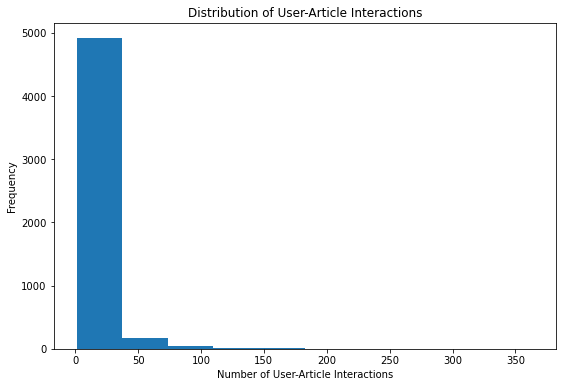

In [6]:
# plot graph
plt.figure(figsize=(9,6))
user_interacts.plot(kind='hist')
plt.title('Distribution of User-Article Interactions') 
plt.xlabel('Number of User-Article Interactions');

In [7]:
median_val = user_interacts.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_interacts.max() # The maximum number of user-article interactions by any 1 user is ______.

In [8]:
# Exploring duplicate articles
df_content.article_id.duplicated().sum()

5

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

In [10]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [11]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [12]:
most_viewed_article_id = str(df.article_id.value_counts().index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts().iloc[0] # The most viewed article in the dataset was viewed how many times?

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In these part, I considered the popularity of an article only be based on how often an article was interacted with. It is because the dataset does not have ratings for whether a user liked an article or not.


In [13]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]
 
    return top_articles # Return the top article ids

In [14]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [15]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below is to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** only appears in each **row** once.

* Each **article** only shows up in one **column**.  

* **If a user has interacted with an article, I place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  

* **If a user has not interacted with an item, I placed a zero where the user-row meets for that article-column**. 


In [16]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_count = df.groupby(['user_id', 'article_id']).count().reset_index() # create a new df based on count
    user_item = df_count.pivot_table(values='title', index='user_id', columns='article_id') # pivot so users on rows and article on columns
    user_item.replace(np.nan, 0, inplace=True) # replace nulls with 0s
    user_item=user_item.applymap(lambda x: 1 if x > 0 else x) # entries should be a 1 or 0
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [17]:
pickle.dump( user_item, open( "user_item_matrix.p", "wb" ) )

In [18]:
## Test the function
user_item.shape[0]

5149

In [19]:
user_item.shape[1]

714

In [20]:
user_item.sum(axis=1)[1]

36.0

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dot_prod_users = user_item.dot(np.transpose(user_item))
    
    # sort by similarity
    sim_users = dot_prod_users[user_id].sort_values(ascending = False)
    
    # create list of just the ids
    most_similar_users = sim_users.index.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [22]:
# Test the function
find_similar_users(1)[:10]

[3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]

In [23]:
find_similar_users(3933)[:5]

[1, 23, 3782, 203, 4459]

In [24]:
find_similar_users(46)[:3]

[4201, 3782, 23]

In [25]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype('str')
    
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title']) # need to use df instead of df_content as it only has 1051 rows
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = np.array([]) # recommendations to be made
    
    user_articles_seen = get_user_articles(user_id)[0] #seen by our user
    closest_users = find_similar_users(user_id) # users closest to our user
    
    for others in closest_users:
        
        others_articles_seen = get_user_articles(others)[0] # articles seen by others like our user
        new_recs = np.setdiff1d(others_articles_seen, user_articles_seen, assume_unique=True) #find those not seen by user
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) # concate arrays and only return unique values

        if len(recs) > m-1:
            break
            
    recs = recs[:m]
    recs.tolist()
    
    return recs # return your recommendations for this user_id    

In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [27]:
get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

['using deep learning to reconstruct high-resolution audio',
 'build a python app on the streaming analytics service',
 'gosales transactions for naive bayes model',
 'healthcare python streaming application demo',
 'use r dataframes & ibm watson natural language understanding',
 'use xgboost, scikit-learn & ibm watson machine learning apis']

In [28]:
get_user_articles(20)[0]

Index(['232.0', '844.0', '1320.0'], dtype='object', name='article_id')

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - I choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, I choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create neighbors dataframe with empty columns
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity'])
    # set neighbor_id column equal to user_item index starting from 1
    neighbors_df['neighbor_id'] = user_item.index-1
    # make similarity column equal to most similar using dot product 
    dot_prod_users = user_item.dot(np.transpose(user_item))
    neighbors_df['similarity'] = dot_prod_users[user_id]
    # create new df based on number of interactions of users
    interacts_df = df.user_id.value_counts().rename_axis('neighbor_id').reset_index(name='num_interactions')
    # merge dataframes which creates number of interactions column from interacts_df
    neighbors_df = pd.merge(neighbors_df, interacts_df, on='neighbor_id', how='outer')
    # sortvalues on similarity and then number of interactions 
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending = False)
    # reset index
    neighbors_df = neighbors_df.reset_index(drop=True)
    # drop row with the user_id as itself will be most similar
    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = np.array([]) # recommendations to be made
    
    user_articles_ids_seen, user_articles_names_seen = get_user_articles(user_id, user_item) #article ids seen by our user
    closest_neighs = get_top_sorted_users(user_id, df, user_item).neighbor_id.tolist() # neighbour user ids closest to our user
    
    for neighs in closest_neighs:
        
        neigh_articles_ids_seen, neigh_articles_names_seen = get_user_articles(neighs, user_item) # articles seen by others like our user
        new_recs = np.setdiff1d(neigh_articles_ids_seen, user_articles_ids_seen, assume_unique=True) #find those not seen by user
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) # concate arrays and only return unique values

        if len(recs) > m-1:
            break
            
    recs = recs[:m]
    recs = recs.tolist() # convert to a list
    
    rec_names = get_article_names(recs, df=df)
    
    return recs, rec_names

In [30]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


In [31]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # The user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id# The 10th most similar user to user 131

If there is a new user, I use Rank based recommendations to new users with the most popular articles. The function for it is get_top_article_ids.

In [32]:
dfTemp = df
dfTemp = dfTemp.drop_duplicates(subset=['article_id'], keep='first', inplace=False)
dfTemp = dfTemp.reset_index(drop=True)

In [33]:
df.shape

(45993, 3)

In [34]:
dfTemp.shape

(714, 3)

In [35]:
dfTemp.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [36]:
def rec_new_uer(list):
    ans = []
    for user in list:
        ans.append(dfTemp[dfTemp.article_id==float(user)].title.item())
    return ans

In [37]:
new_user = '0.0'
#The list of top 10 recommendations to a new user '0.0'. 
new_user_recs = get_top_article_ids(10, df)
new_user_recs


['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [38]:
ans = rec_new_uer(new_user_recs)
ans

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, I will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [47]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [48]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Below, I will use Singular Value Decomposition on the user-item matrix.

In [49]:
# SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

By increasing the number of latent features, the obtained error rate gets lower on making predictions for the 1 and 0 values in the user-item matrix.

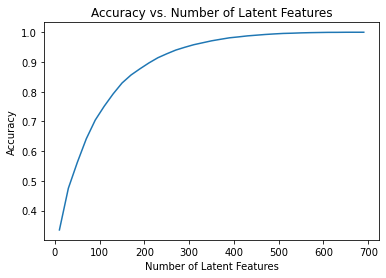

In [50]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [51]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = set(user_item_train.index)
    test_idx = set(user_item_test.index)
    match_idx = list(train_idx.intersection(test_idx))
    
    train_arts = set(user_item_train.columns)
    test_arts =  set(user_item_test.columns)
    match_cols = list(train_arts.intersection(test_arts))

    user_item_test = user_item_test.loc[match_idx, match_cols]

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [52]:
test_idx

{2917,
 3024,
 3093,
 3193,
 3527,
 3532,
 3684,
 3740,
 3777,
 3801,
 3968,
 3989,
 3990,
 3998,
 4002,
 4204,
 4231,
 4274,
 4293,
 4487,
 4488,
 4489,
 4490,
 4491,
 4492,
 4493,
 4494,
 4495,
 4496,
 4497,
 4498,
 4499,
 4500,
 4501,
 4502,
 4503,
 4504,
 4505,
 4506,
 4507,
 4508,
 4509,
 4510,
 4511,
 4512,
 4513,
 4514,
 4515,
 4516,
 4517,
 4518,
 4519,
 4520,
 4521,
 4522,
 4523,
 4524,
 4525,
 4526,
 4527,
 4528,
 4529,
 4530,
 4531,
 4532,
 4533,
 4534,
 4535,
 4536,
 4537,
 4538,
 4539,
 4540,
 4541,
 4542,
 4543,
 4544,
 4545,
 4546,
 4547,
 4548,
 4549,
 4550,
 4551,
 4552,
 4553,
 4554,
 4555,
 4556,
 4557,
 4558,
 4559,
 4560,
 4561,
 4562,
 4563,
 4564,
 4565,
 4566,
 4567,
 4568,
 4569,
 4570,
 4571,
 4572,
 4573,
 4574,
 4575,
 4576,
 4577,
 4578,
 4579,
 4580,
 4581,
 4582,
 4583,
 4584,
 4585,
 4586,
 4587,
 4588,
 4589,
 4590,
 4591,
 4592,
 4593,
 4594,
 4595,
 4596,
 4597,
 4598,
 4599,
 4600,
 4601,
 4602,
 4603,
 4604,
 4605,
 4606,
 4607,
 4608,
 4609,
 4610,

In [53]:
train_idx = user_item_train.index # 4487 users in training set
train_idx

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487],
           dtype='int64', name='user_id', length=4487)

In [56]:
test_arts #574 movies in test set

{0.0,
 2.0,
 4.0,
 8.0,
 9.0,
 12.0,
 14.0,
 15.0,
 16.0,
 18.0,
 20.0,
 25.0,
 26.0,
 28.0,
 29.0,
 30.0,
 32.0,
 33.0,
 34.0,
 36.0,
 39.0,
 40.0,
 43.0,
 48.0,
 50.0,
 51.0,
 53.0,
 54.0,
 57.0,
 58.0,
 59.0,
 60.0,
 62.0,
 64.0,
 65.0,
 68.0,
 74.0,
 76.0,
 77.0,
 78.0,
 80.0,
 81.0,
 82.0,
 87.0,
 89.0,
 92.0,
 96.0,
 98.0,
 100.0,
 101.0,
 102.0,
 103.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 115.0,
 116.0,
 117.0,
 120.0,
 122.0,
 124.0,
 125.0,
 130.0,
 131.0,
 132.0,
 134.0,
 136.0,
 138.0,
 142.0,
 143.0,
 145.0,
 146.0,
 151.0,
 152.0,
 153.0,
 157.0,
 158.0,
 162.0,
 164.0,
 173.0,
 176.0,
 181.0,
 183.0,
 184.0,
 188.0,
 189.0,
 191.0,
 193.0,
 194.0,
 195.0,
 202.0,
 205.0,
 210.0,
 213.0,
 215.0,
 221.0,
 223.0,
 224.0,
 225.0,
 230.0,
 232.0,
 233.0,
 234.0,
 236.0,
 237.0,
 239.0,
 240.0,
 241.0,
 244.0,
 250.0,
 251.0,
 252.0,
 253.0,
 254.0,
 256.0,
 258.0,
 260.0,
 263.0,
 266.0,
 268.0,
 270.0,
 273.0,
 277.0,
 278.0,
 283.0,
 284.0,
 288.0,
 291.

In [57]:
train_arts = user_item_train.columns #714 movies in train set
train_arts

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0,
              1443.0, 1444.0],
             dtype='float64', name='article_id', length=714)

In [58]:
test_arts.difference(train_arts) # all articles in test set are in training set too

set()

In [63]:
count_users_cold_start = 0
for item in set(df_test['user_id']):
    if item not in set(df_train['user_id']):
        count_users_cold_start += 1
print(count_users_cold_start) # The number of users in the test set that I was not able to make predictions for because of the cold start problem
print(len(set(df_test['user_id'])))

count_articles_cold_start = 0
for article in set(df_test['article_id']):
    if article not in set(df_train['article_id']):
        count_articles_cold_start += 1
print(count_articles_cold_start) # The number of movies in the test set are that I was not able to make predictions for because of the cold start problem

662
682
0


In [64]:
len(test_arts) # The number of movies that I could make predictions for in the test set

574

In [65]:
print(user_item_test.shape[0]) 

20


In [66]:
len(set(df_test['user_id'])) - count_users_cold_start # The number of users I could make predictions for in the test set

20

In [67]:
test_arts

{0.0,
 2.0,
 4.0,
 8.0,
 9.0,
 12.0,
 14.0,
 15.0,
 16.0,
 18.0,
 20.0,
 25.0,
 26.0,
 28.0,
 29.0,
 30.0,
 32.0,
 33.0,
 34.0,
 36.0,
 39.0,
 40.0,
 43.0,
 48.0,
 50.0,
 51.0,
 53.0,
 54.0,
 57.0,
 58.0,
 59.0,
 60.0,
 62.0,
 64.0,
 65.0,
 68.0,
 74.0,
 76.0,
 77.0,
 78.0,
 80.0,
 81.0,
 82.0,
 87.0,
 89.0,
 92.0,
 96.0,
 98.0,
 100.0,
 101.0,
 102.0,
 103.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 115.0,
 116.0,
 117.0,
 120.0,
 122.0,
 124.0,
 125.0,
 130.0,
 131.0,
 132.0,
 134.0,
 136.0,
 138.0,
 142.0,
 143.0,
 145.0,
 146.0,
 151.0,
 152.0,
 153.0,
 157.0,
 158.0,
 162.0,
 164.0,
 173.0,
 176.0,
 181.0,
 183.0,
 184.0,
 188.0,
 189.0,
 191.0,
 193.0,
 194.0,
 195.0,
 202.0,
 205.0,
 210.0,
 213.0,
 215.0,
 221.0,
 223.0,
 224.0,
 225.0,
 230.0,
 232.0,
 233.0,
 234.0,
 236.0,
 237.0,
 239.0,
 240.0,
 241.0,
 244.0,
 250.0,
 251.0,
 252.0,
 253.0,
 254.0,
 256.0,
 258.0,
 260.0,
 263.0,
 266.0,
 268.0,
 270.0,
 273.0,
 277.0,
 278.0,
 283.0,
 284.0,
 288.0,
 291.

In [68]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [69]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [70]:
# decomposition to predict on test data
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

In [71]:

row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

In [72]:
num_latent_feats = np.arange(0,700+10,20)
sum_errs_train = []
sum_errs_test = []
all_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

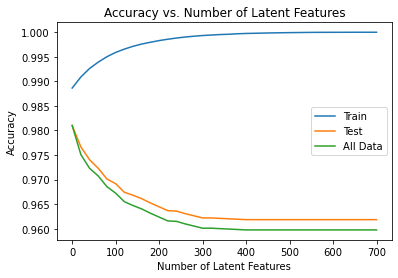

In [73]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.plot(num_latent_feats, all_errs, label='All Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

Only 20 users in the test data can be predicted using SVD. For other users, we would have to use rank based recommendations or content based recommendations. We can use A/B testing to measure the effectiveness of these two methods by providing 50% of the users rank based recommendations and the other 50% of the users content based recommendations. Whichever of these methods gives us better performance, we can use that method (rank based or content based) to recommend articles.</b></p>

In [74]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1